# Artigo 2: Deploy do Modelo de Aprendizado de Máquina Trabalhado No Artigo "Identificar o que é jogo de tiro e jogo de futebol" 

## Autor
- **Levi de Oliveira Queiroz**
- **Matrícula: 170108341**
- **GitHub: LeviQ27**

## Objetivo 

O objetivo do presente trabalho é demonstrar a criação de um exemplo de um aplicativo visual de computação do modelo de aprendizado de máquina produzido no artigo 1, com algumas alterações em sua linha de código. Demonstrando também o Deploy do modelo em um aplicativo web. Isso aplicando os conhecimentos adquiridos na lição 2 "From Model to Production".

## Desenvolvimento 

O projeto estará compilando uma diferença entre jogo de tiro, jogo de futebol e, de forma adicional, jogo de fantasia. E tem-se uma coleção de imagens na internet para poder processar os dados. Assim, usando a função ```search_images_ddg``` da biblioteca ```duckduckgo_search```, foi adicionado algumas url's de imagen de jogo de fantasia. 

Contudo, para ser iniciado a busca pela url, foi instalado a biblioteca biblioteca do ```fastbook``` seguindo a diretriz do livro criado pelo seu Howard:

In [1]:
%pip install -Uqq fastbook

Note: you may need to restart the kernel to use updated packages.


In [2]:
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.widgets import *

Em seguida, é definido a função ```search_images_ddg```:

In [3]:
search_images_ddg

<function fastbook.search_images_ddg(term, max_images=200)>

Em seguida, a função ```search_images_ddg``` vai baixar algumas url's de imagem de jogo de fantasia para a variável ```ims```:

In [4]:
ims = search_images_ddg('fantasy game')
len(ims)

200

Certo, a funçao ```search_images_ddg``` baixou 200 url's de imagens de jogo de fantasia. Em seguida, é verificado uma imagem das url's baixadas, para verificar se a função funcionou como foi ordenada:

In [5]:
dest = 'images/fantasygame.jpg'
download_url(ims[0], dest, show_progress=False)

Path('images/fantasygame.jpg')

Agora, depois de selecionado uma url, é verificado a imagem:

> Note que é criado uma varial que recebe a visualização da imagem e essa imagem através do ```to_thumb``` é redimensionada.

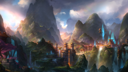

In [6]:
im = Image.open(dest)
im.to_thumb(128,128)

Observado que a função retornou dentro do esperado, é usando a função ```download_images``` para trazer as imagens, através de suas url's, necessárias para a continuação do presente trabalho, em que será puxado as url"s de jogos de tiro, futebol e fantasia:

> Note que as imagens ficaram em pastas separadas

In [7]:
game_types = 'shooting videogame','soccer videogame','fantasy videogame'
path = Path('games')

In [8]:
if not path.exists():
    path.mkdir()
    for o in game_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o} image')
        download_images(dest, urls=results)

Assim como foi observado, foi criado a pasta ```games``` em que há as três subpastas com as imagens:

> É utilizado a função ```get_image_files``` para olhar o caminho das imagens baixadas nos arquivos

In [9]:
fns = get_image_files(path)
fns

(#539) [Path('games/soccer videogame/65ccf37b-8ac0-452c-8a69-b1b676eaf33f.jpg'),Path('games/soccer videogame/e9f8b788-44fb-4240-ab53-7f375d31e1b9.jpg'),Path('games/soccer videogame/90f76c0d-3193-4712-9fde-ad317051216e.jpg'),Path('games/soccer videogame/48cc5d6b-c4d5-4400-9a7a-fa491e4aa826.png'),Path('games/soccer videogame/a94e2503-9d1d-4039-92b4-73b553d8c3dd.jpg'),Path('games/soccer videogame/81dc6eb6-725e-4bf3-a123-b489b6946a7a.jpg'),Path('games/soccer videogame/43c77951-ace0-4831-8e29-5279cd43dd3a.jpg'),Path('games/soccer videogame/c6229e05-e067-4c19-a0ca-fc90cd6346af.jpg'),Path('games/soccer videogame/2453eab2-8d32-4204-82ba-75d684600464.jpg'),Path('games/soccer videogame/490cae92-f195-4bf2-8cde-77db232b3bfb.jpg')...]